# <u>Subreddit prediction</u> #



## 1. Description of the project ##

### <span style="color: #FF9800;">Project overview </span> ###


This project aims to develop machine learning models for **analyzing Reddit text** to determine the origin subreddit of a given post or comment. Reddit, a popular social media platform, is organized into a variety of thematic communities known as *subreddits*, where users share content and engage in discussions.



### <span style="color: #FF9800;">Objective </span> ###


The primary objective is to build a model that can **predict the subreddit** of a Reddit post or comment. Given a text entry from Reddit, the model will identify which of the following subreddits it originally came from:

- **Toronto**
- **Brussels**
- **London**
- **Montreal**

<b>This defines a multiclass classification problem</b>


### <span style="color: #FF9800;">Approach</span> ###



This project consists of two main parts:

1. **Implement a Bernoulli Naïve Bayes Classifier from Scratch**  
   First, a Bernoulli Naïve Bayes classifier will be developed from the ground up, without relying on external libraries for the core algorithm. This implementation will provide a deeper understanding of how the Bernoulli Naïve Bayes method works and how it can be applied to text classification.

2. **Utilize a Classifier from Scikit-Learn**  
   In the second part, a pre-built classifier from the `scikit-learn` library will be used to perform the same task. This comparison will allow us to evaluate the effectiveness of our custom implementation against a widely used, optimized machine learning library.


## 2. Modules importation ##

### <span style="color: #FF9800;">Module importation </span> ###

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import seaborn as ss

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, words

import langid
import re

# Ensure required NLTK resources are downloaded
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('words')

except Exception as e:
    print(f"Error downloading NLTK resources: {e}")

# Define stopwords list
specific_stopwords = ["https", "subreddit", "www", "com"] ## some specific words for the given dataset
stopwords_list = stopwords.words('english') +specific_stopwords + stopwords.words('french') # dataset is both in english and in french


[nltk_data] Downloading package punkt to /home/clatimie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/clatimie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /home/clatimie/nltk_data...
[nltk_data]   Package words is already up-to-date!


## 3. Bernoulli Naïve Bayes Classifier 


In [2]:
# Bernoulli Naïve Bayes
class NaiveBayesClassifier:    
    def __init__(self, laplace_alpha, unique_labels):
        self.alpha = laplace_alpha  # true for performing Laplace smoothing
        self.classes = unique_labels
        self.thetak = None
        self.theta_j_k = None

    def fit(self, X, y):
        # Laplace smoothing parameters
        n_k = self.classes.shape[0]  # number of classes
        n_j = X.shape[1]  # number of features
        n_samples = X.shape[0] # number of samples

        self.theta_k = np.zeros(n_k)  # probability of class k
        self.theta_j_k = np.zeros((n_k, n_j))  # probability of feature j given class k

        # compute parameters
        for k in range(n_k):
            count_k = (y==self.classes[k]).sum()
            self.theta_k[k] = count_k / n_samples
            for j in range(n_j):
                self.theta_j_k[k][j] = (X[y==self.classes[k], j].sum()+self.alpha) / (count_k+2*self.alpha)

    def predict(self, X):
        theta_k = self.theta_k  # Prior probabilities P(y)
        theta_j_k = self.theta_j_k  # Conditional probabilities P(X|y) for each feature and class

        # Calculate log probabilities for P(y) and P(X|y)
        log_theta_k = np.log(theta_k)  # Shape (num_classes,)
        log_theta_j_k = np.log(theta_j_k)  # Shape (num_classes, num_features)
        log_one_minus_theta_j_k = np.log(1 - theta_j_k)  # Shape (num_classes, num_features)

        # Calculate the log probabilities of each sample in X for each class
        probs = (X @ log_theta_j_k.T) + ((1 - X) @ log_one_minus_theta_j_k.T) + log_theta_k

        # Choose the class with the highest probability
        y_pred = np.argmax(probs, axis=1)

        # Transform back to text-based values (class labels)
        return self.classes[y_pred]

    
    def accu_eval(self, X, y):
        # Predict the classes for the input data
        predicted_classes = self.predict(X)
        
        # Ensure the predicted classes are in the correct shape
        # If predicted_classes is already 1D, reshaping is not necessary
        if predicted_classes.ndim == 1:
            predicted_classes = predicted_classes.reshape((-1, 1))

        # Convert y to a NumPy array if it's a Pandas Series
        if isinstance(y, pd.Series):
            y = y.to_numpy()
        
        # Calculate accuracy: compare predicted classes with true labels
        accuracy = np.mean(predicted_classes.flatten() == y.flatten())
        accuracy_per_class = np.zeros((len(self.classes)))


        # Calculate accuracy per class
        for i, cls in enumerate(self.classes):
            # Find indices where the true label is the current class
            class_indices = (y == cls)
        
            # Calculate the accuracy for the current class
            if np.sum(class_indices) > 0:  # Avoid division by zero
                accuracy_per_class[i] = np.mean(predicted_classes[class_indices] == y[class_indices])

        return accuracy, accuracy_per_class
    
    def k_fold_cross_validation(self, k, X, y, print_info=True):
        # Performs k-fold cross-validation to evaluate the model's performance
        num_samples = X.shape[0]  # Get number of samples in dataset

        indices = np.arange(num_samples)
        np.random.shuffle(indices)  # Shuffle the indices
        X = X[indices]  # Apply shuffled indices to X
        y = y[indices]  # Apply shuffled indices to y to maintain correspondence

        fold_size = num_samples // k  # Calculate size of each fold
        accuracies = []  # Initialize list to store accuracies for each fold
        accuracies_training = []  # Initialize list for training accuracies
        accuracies_per_class = []

        for fold in range(k):
            if print_info:
                print(f"\nFold : {fold + 1}")  # Print current fold number
            test_start = fold * fold_size  # Start index for test set
            test_end = (fold + 1) * fold_size if fold < k - 1 else num_samples  # End index for test set
                
            X_test = X[test_start:test_end, :]  # Create test set
            y_test = y[test_start:test_end]  # Corresponding target values for test set

            X_train = np.vstack((X[:test_start, :], X[test_end:, :]))  # Create training set
            y_train = np.concatenate((y[:test_start], y[test_end:]))  # Corresponding target values for training set
            if print_info:
                print(f"Class distribution within training dataset :")  # Print class distribution
                for k in range(0, len(self.classes)):
                    print(f'Proportion of class {self.classes[k]} : {np.sum(y_train==self.classes[k])/len(y_train)*100} %')

            self.fit(X_train, y_train)  # Fit model on training set
            accu_valid, accu_valid_per_class = self.accu_eval(X_test, y_test) # Evaluate accuracy on test set
            accuracies.append(accu_valid)
            accuracies_per_class.append(accu_valid_per_class)
            accu_training,_ = self.accu_eval(X_train, y_train) 
            accuracies_training.append(accu_training)  # Evaluate accuracy on training set
            if print_info:
                print(f"\n Accuracy = {accuracies[-1]}")  # Print accuracy for current fold
                print(f"\n Accuracies per class {accuracies_per_class[-1]}")

        accuracies = np.array(accuracies)  # Convert accuracies list to NumPy array

        mean_accuracies = np.mean(accuracies)  # Calculate mean accuracy across folds
        mean_accuracies_training = np.mean(accuracies_training)  # Calculate mean training accuracy across folds
        std_accuracies = np.std(accuracies)  # Calculate standard deviation of accuracies
        mean_accu_per_class = np.mean(np.array(accuracies_per_class), axis=0)

        return mean_accuracies, std_accuracies, mean_accuracies_training, mean_accu_per_class 
    
    def predict_and_save(self, x, path):
        # Example of how to predict classes
        predicted_classes = self.predict(x)[:, 0]

        # Create a DataFrame to hold the predictions with an 'id' column
        df_predictions = pd.DataFrame({
            'id': np.arange(len(predicted_classes)),  # Creates an ID column starting from 0
            'subreddit': predicted_classes            # Use the predicted classes as subreddit names
        })

        # Save the DataFrame to a CSV file
        df_predictions.to_csv(path, index=False)

## 4. Dataset analysis

### <span style="color: #FF9800;">Load training dataset</span> ###

In [3]:
np.random.seed(10) # set a random seed to make results reproductible

In [4]:
# Define the path to the training data file
path_training = "../datasets/Train.csv"

# Read the CSV file into a pandas DataFrame
training_data = pd.read_csv(path_training, delimiter=',')

# Set column names explicitly for better readability
training_data.columns = ['text', 'subreddit']

# Shuffle dataset
training_data = training_data.sample(frac=1, random_state=42).reset_index(drop=True) 

# Separate the training data into two series: texts and subreddit labels
texts_train = training_data['text']          # Contains the Reddit posts or comments
subreddits_train = training_data['subreddit'] # Contains the subreddit each post originates from

# Get unique subreddit labels
unique_labels = np.unique(subreddits_train)   # List of unique subreddits in the dataset

n_samples_training = texts_train.shape[0]
n_classes = unique_labels.shape[0]

print(f"Training dataset has {n_samples_training} examples and there are {n_classes} classes")

Training dataset has 1399 examples and there are 4 classes


### <span style="color: #FF9800;">Load test dataset</span> ###

In [5]:
# Define the path to the training data file
path_test = "../datasets/Test.csv"

# Read the CSV file into a pandas DataFrame
texts_test = pd.read_csv(path_test, delimiter=',')["body"]

n_samples_test = texts_test.shape[0]
print(f"Test dataset has {n_samples_test} examples")


Test dataset has 600 examples


### <span style="color: #FF9800;">Inspect training dataset</span> ###

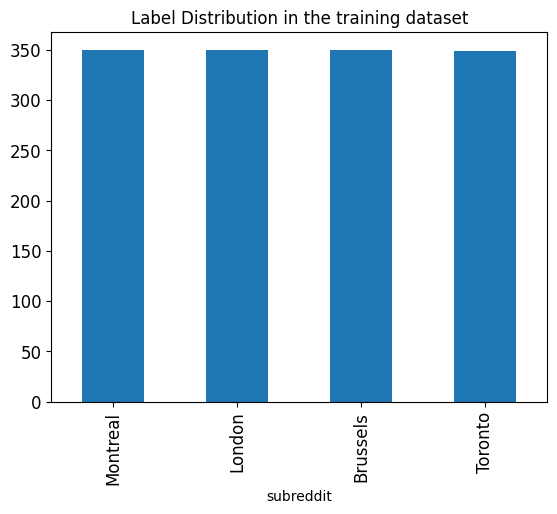

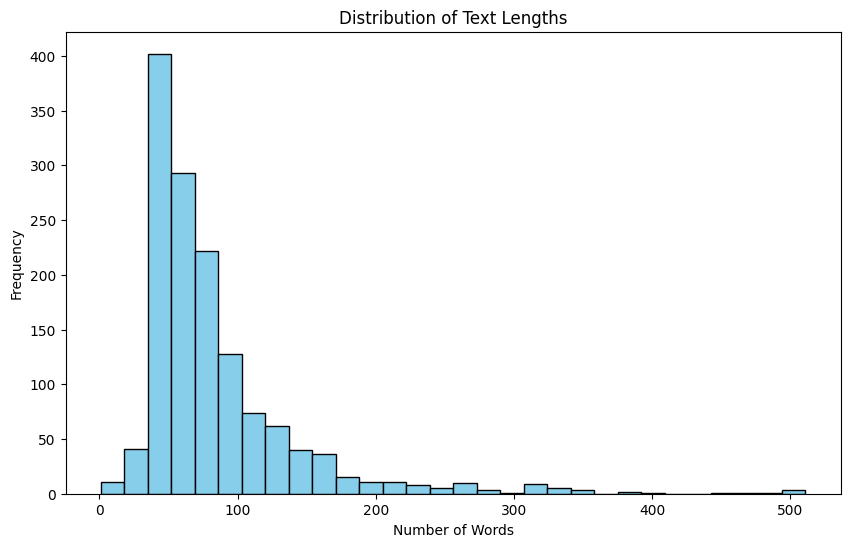

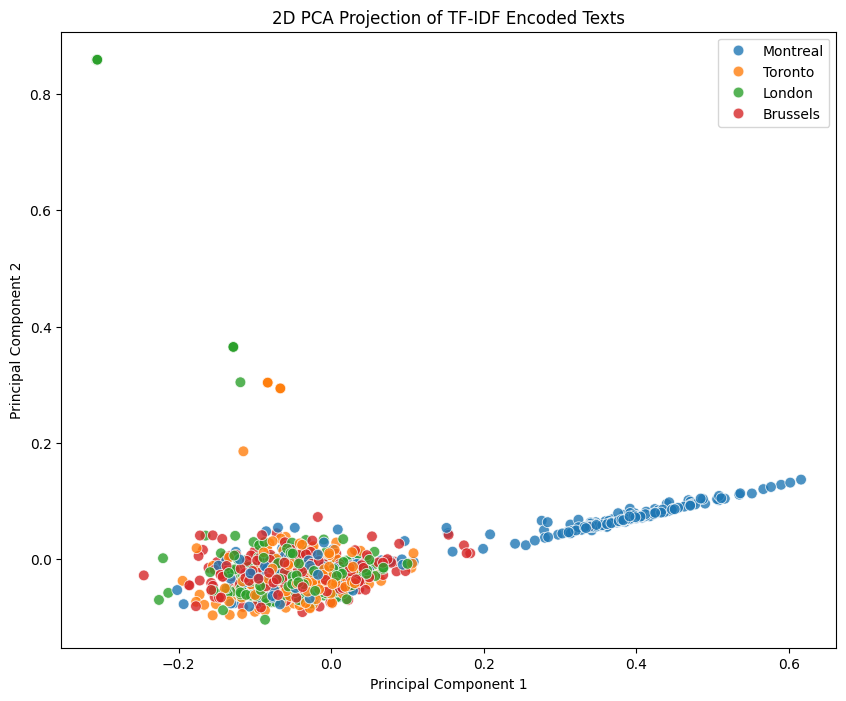

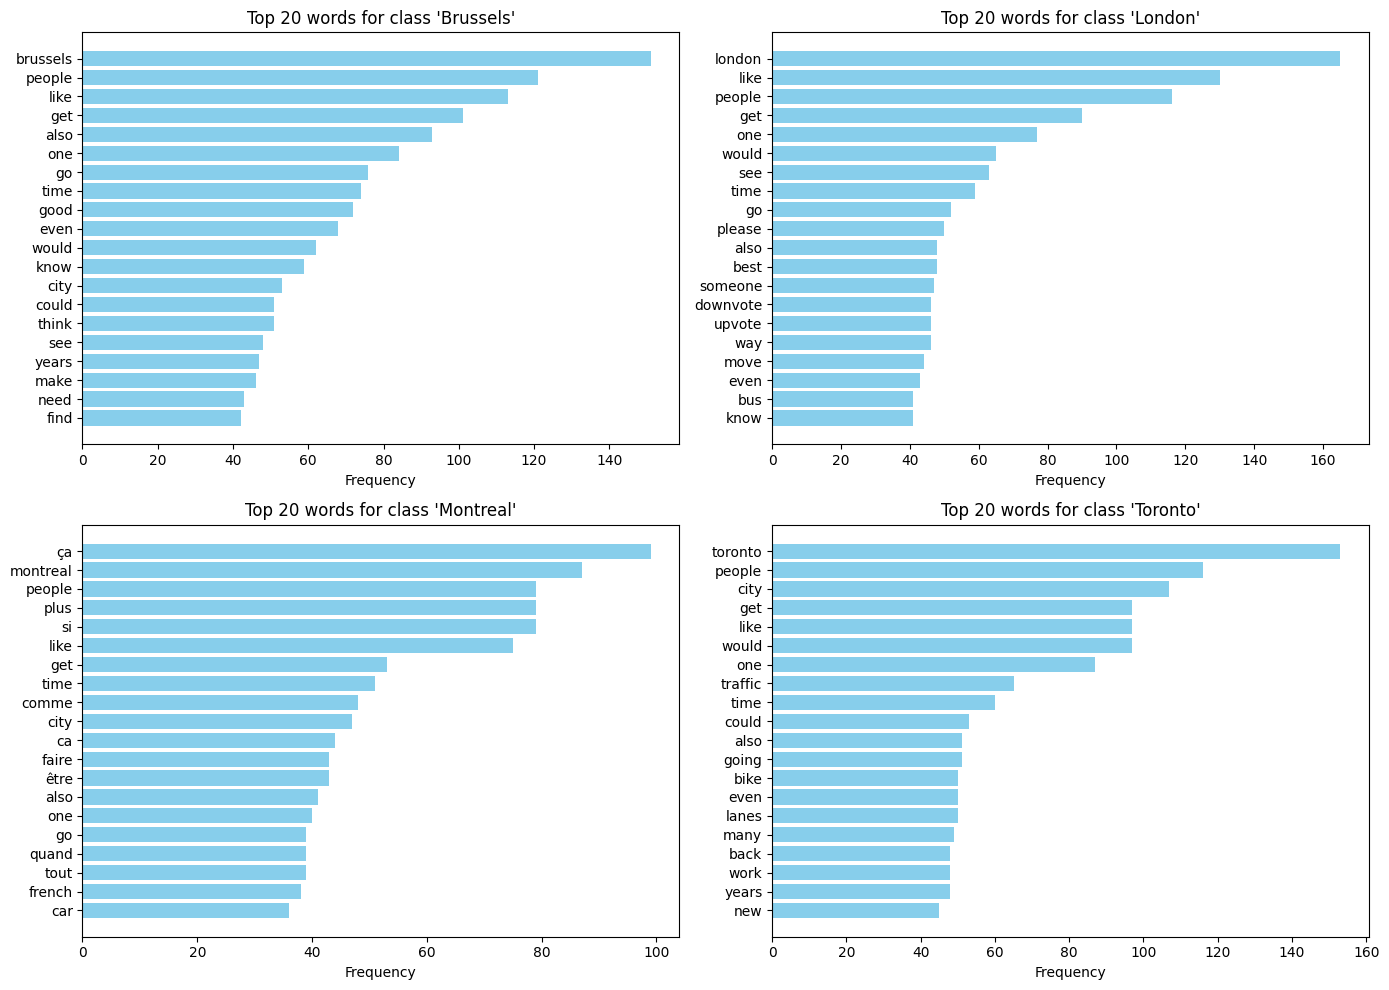

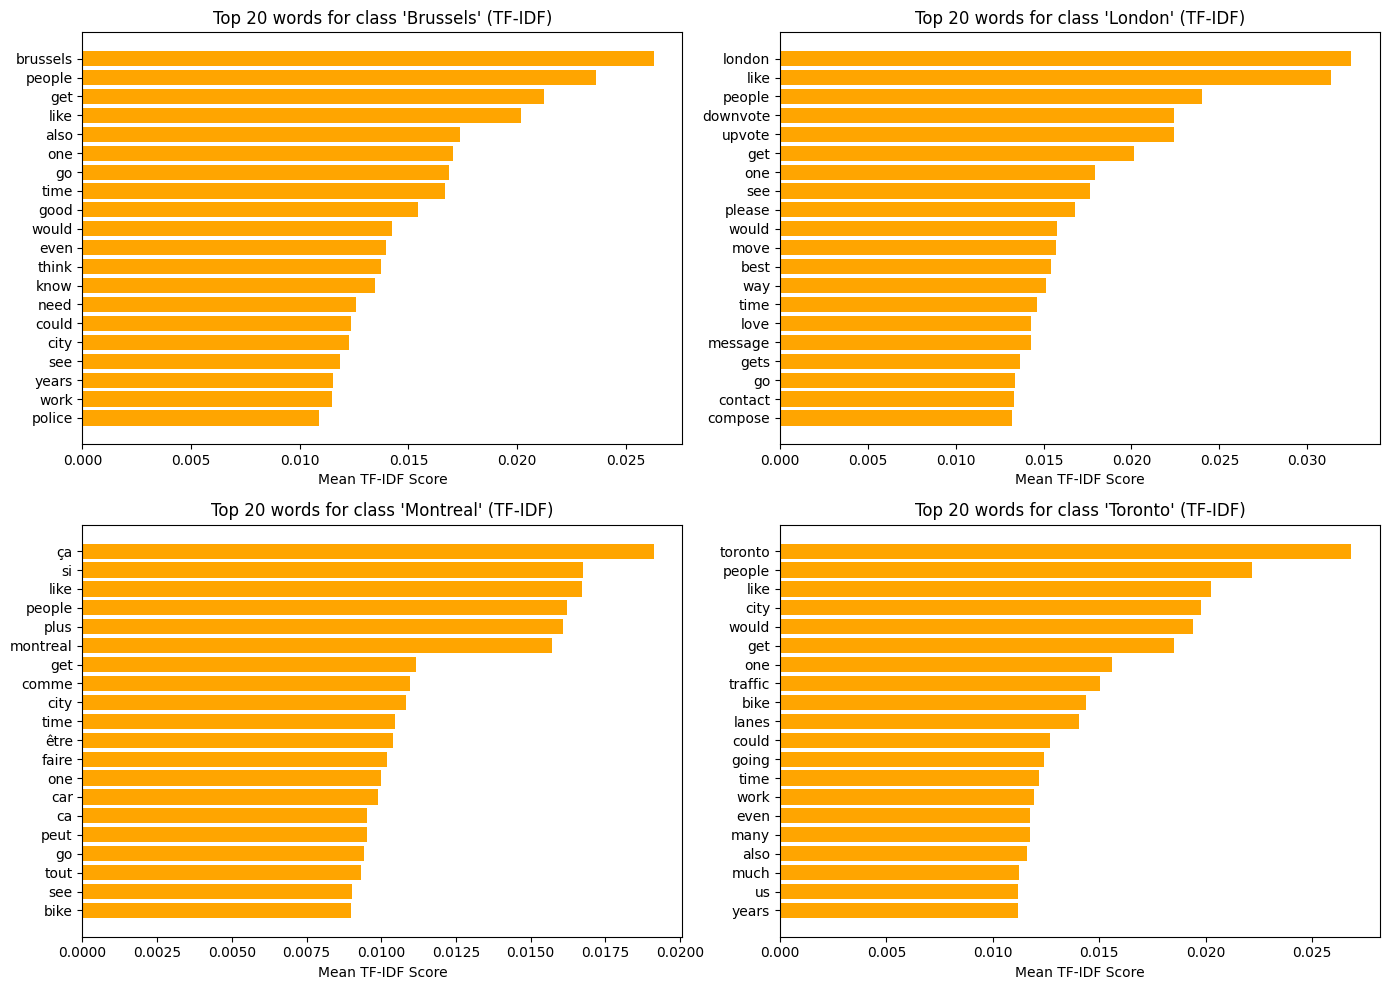

In [6]:
# Show distribution of examples per class 
df = pd.DataFrame(training_data)
# Count the number of samples for each label
label_counts = df['subreddit'].value_counts()
# Plot the distribution
label_counts.plot(kind='bar', title='Label Distribution in the training dataset', fontsize=12)

# Calculate the length of each text (in words)
text_lengths = texts_train.apply(lambda x: len(x.split()))

# Plot a histogram of text lengths
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# PCA Analysis with TFIDF vectorization
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(texts_train)

# Use PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Plot the PCA result with labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=subreddits_train, palette='tab10', s=60, alpha=0.8)
plt.title("2D PCA Projection of TF-IDF Encoded Texts")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc='best')
plt.show()

# Plot the most frequent words for each label in a single figure
def plot_most_frequent_words_per_class(top_freq, texts_train, y_train):
    unique_labels = sorted(set(y_train))  # Get unique classes
    n_labels = len(unique_labels)

    # Set up the figure with 2x2 subplots (adjust if you have more/less than 4 classes)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Adjust grid size if needed
    axes = axes.flatten()  # Flatten axes array for easy indexing

    for i, label in enumerate(unique_labels):
        # Initialize the vectorizer
        vectorizer = CountVectorizer(stop_words=stopwords_list)
        
        # Filter the texts for the given label
        label_texts = [text for text, lbl in zip(texts_train, y_train) if lbl == label]
        word_counts = vectorizer.fit_transform(label_texts)
        
        # Sum up the counts of each word
        word_freq = word_counts.sum(axis=0).A1  # Flatten to get a 1D array of word frequencies
        words = vectorizer.get_feature_names_out()

        # Create a dictionary of words and their frequencies
        word_freq_dict = dict(zip(words, word_freq))

        # Sort the dictionary by frequency in descending order
        sorted_word_freq = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)

        # Select the top N most frequent words
        top_words = sorted_word_freq[:top_freq]
        top_words, top_freqs = zip(*top_words)

        # Plot the most frequent words for this class in the subplot
        ax = axes[i]
        ax.barh(top_words, top_freqs, color='skyblue')
        ax.set_xlabel("Frequency")
        ax.set_title(f"Top {top_freq} words for class '{label}'")
        ax.invert_yaxis()  # Invert y-axis to have the most frequent words on top

    # Adjust layout and show the figure
    plt.tight_layout()
    plt.show()

plot_most_frequent_words_per_class(20, texts_train, subreddits_train)

# Plot the most frequent words for each label using TF-IDF scores
def plot_most_important_words_per_class_tfidf(top_freq, texts_train, y_train):
    unique_labels = sorted(set(y_train))  # Get unique classes
    n_labels = len(unique_labels)

    # Set up the figure with 2x2 subplots (adjust if you have more/less than 4 classes)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Adjust grid size if needed
    axes = axes.flatten()  # Flatten axes array for easy indexing

    for i, label in enumerate(unique_labels):
        # Initialize the TF-IDF vectorizer
        vectorizer = TfidfVectorizer(stop_words=stopwords_list)
        
        # Filter the texts for the given label
        label_texts = [text for text, lbl in zip(texts_train, y_train) if lbl == label]
        tfidf_matrix = vectorizer.fit_transform(label_texts)
        
        # Calculate mean TF-IDF scores for each word across all documents in this class
        mean_tfidf_scores = tfidf_matrix.mean(axis=0).A1  # Get average scores for each term
        words = vectorizer.get_feature_names_out()

        # Create a dictionary of words and their mean TF-IDF scores
        word_tfidf_dict = dict(zip(words, mean_tfidf_scores))

        # Sort the dictionary by TF-IDF score in descending order
        sorted_word_tfidf = sorted(word_tfidf_dict.items(), key=lambda x: x[1], reverse=True)

        # Select the top N most important words based on TF-IDF score
        top_words = sorted_word_tfidf[:top_freq]
        top_words, top_scores = zip(*top_words)

        # Plot the most important words for this class in the subplot
        ax = axes[i]
        ax.barh(top_words, top_scores, color='orange')
        ax.set_xlabel("Mean TF-IDF Score")
        ax.set_title(f"Top {top_freq} words for class '{label}' (TF-IDF)")
        ax.invert_yaxis()  # Invert y-axis to have the most important words on top

    # Adjust layout and show the figure
    plt.tight_layout()
    plt.show()

# Call the function to plot top words with highest TF-IDF scores for each class
plot_most_important_words_per_class_tfidf(20, texts_train, subreddits_train)


/home/clatimie/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/clatimie/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'etaient', 'etais', 'etait', 'etant', 'etante', 'etantes', 'etants', 'ete', 'etee', 'etees', 'etes', 'etiez', 'etions', 'eumes', 'eutes', 'fume', 'futes', 'meme', 'might', 'must', 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


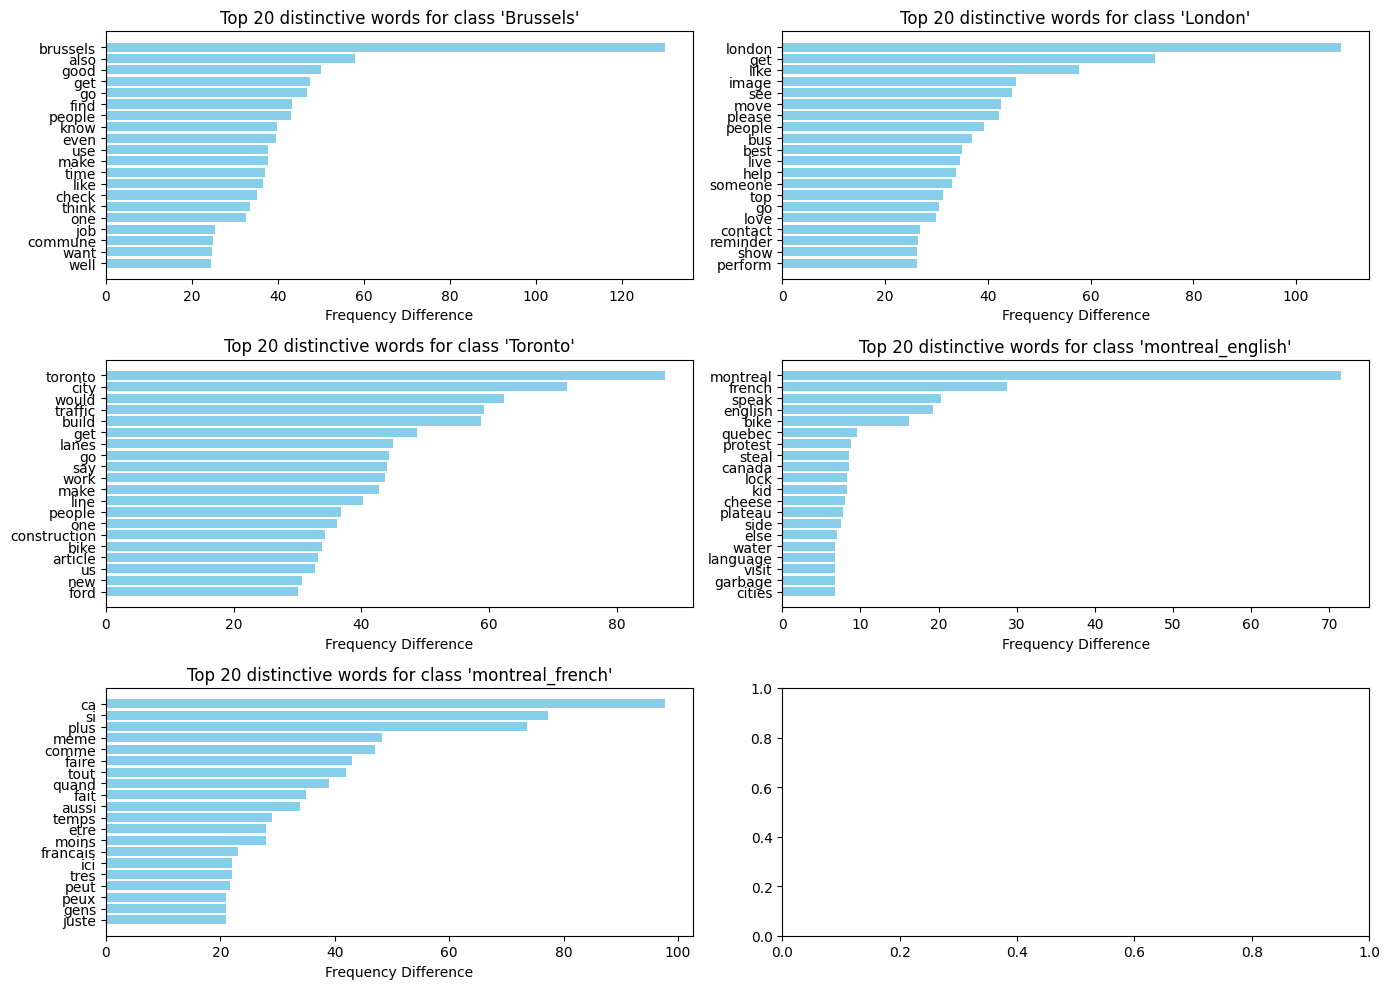

(974,)
Approach 1 : vectorized training dataset has 974 tokens/features


In [ ]:
class LemmaTokenizer:
    def __init__(self, stopwords=None):
        self.wnl = WordNetLemmatizer()
        self.stop_words = stopwords

    def __call__(self, doc):
        # Tokenize the document and apply lemmatization and filtering
        return [
            self.wnl.lemmatize(t, pos="v") for t in word_tokenize(doc)
            if t.isalpha() and t.lower() not in self.stop_words
        ]

# Function to plot most distinctive words for each class using word frequency

# improvement to look at  -> use a weighted score for montréal to select more english words or something like that

def classify_language(comment):
    language, _ = langid.classify(comment)
    return 'montreal_english' if language == 'en' else 'montreal_french' if language == 'fr' else 'montreal_english'

# Modify the labels for comments in the Montreal class
subreddits_mtl_distinct = []  # To hold modified labels

for comment, label in zip(texts_train, subreddits_train):
    if label == 'Montreal':
        language = classify_language(comment)
        subreddits_mtl_distinct.append(language)
    else:
        subreddits_mtl_distinct.append(label)


def plot_most_distinctive_words_frequency(top_n_plot, texts_train, y_train, top_n_selected):
    unique_labels = sorted(set(y_train))  # Get unique classes
    label_texts = {label: [] for label in unique_labels}  # Dictionary to hold texts per class

    # Separate texts by label
    for text, label in zip(texts_train, y_train):
        label_texts[label].append(text)

    # Fit CountVectorizer with the custom tokenizer
    vectorizer = CountVectorizer(
        token_pattern=r'\b[a-zA-Z]{2,}\b',
        stop_words=stopwords_list,
        tokenizer=LemmaTokenizer(stopwords=stopwords_list),
        strip_accents="unicode"
    )
    
    vectorizer.fit(texts_train)
    feature_names = vectorizer.get_feature_names_out()

    # Initialize a dictionary to store word frequencies per class
    word_frequencies = {label: np.zeros(len(feature_names)) for label in unique_labels}

    # Calculate word frequencies for each word in each class
    for label in unique_labels:
        count_matrix = vectorizer.transform(label_texts[label])
        word_frequencies[label] = np.array(count_matrix.sum(axis=0)).flatten()

    # List to hold the top distinctive words across all classes
    all_distinctive_words = []

    # Set up the figure with subplots
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))  # Adjust grid size if needed
    axes = axes.flatten()  # Flatten axes array for easy indexing

    for i, label in enumerate(unique_labels):
        # Calculate distinctiveness by comparing word frequency of this class to the average in other classes
        other_classes = [lbl for lbl in unique_labels if lbl != label]

        if label=="montreal_english":
            avg_freq_other_classes = np.mean([word_frequencies[other_label] for other_label in other_classes if other_label!="montreal_french"], axis=0)
        if label=="montreal_french":
            avg_freq_other_classes = np.mean([word_frequencies[other_label] for other_label in other_classes  if other_label!="montreal_english"], axis=0)
        else:
            avg_freq_other_classes = np.mean([word_frequencies[other_label] for other_label in other_classes], axis=0)

        # Calculate distinctiveness score (frequency in this class minus average frequency in other classes)
        distinctiveness_scores = word_frequencies[label] - avg_freq_other_classes

        # Get the indices of the top N distinctive words
        if label=="montreal_english" or label=="montreal_french":
            top_n_selected_mtl = int(top_n_selected*0.5)
            top_indices = np.argsort(distinctiveness_scores)[-top_n_selected_mtl:][::-1]  # Indices of top N scores in descending order
        else:
            top_indices = np.argsort(distinctiveness_scores)[-top_n_selected:][::-1]  # Indices of top N scores in descending order

        # Select the top N distinctive words and their scores
        distinctive_words = [feature_names[idx] for idx in top_indices]
        distinctive_scores = [distinctiveness_scores[idx] for idx in top_indices]

        # Extend the all_distinctive_words list with the current class's words
        all_distinctive_words.extend(distinctive_words)

        # Plot in the subplot
        ax = axes[i]
        ax.barh(distinctive_words[0:top_n_plot], distinctive_scores[0:top_n_plot], color='skyblue')
        ax.set_xlabel("Frequency Difference")
        ax.set_title(f"Top {top_n_plot} distinctive words for class '{label}'")
        ax.invert_yaxis()  # Invert y-axis to have the most distinctive words on top

    # Adjust layout and show the figure
    plt.tight_layout()
    plt.show()

    # Return the merged list of top distinctive words across all classes
    return list(set(all_distinctive_words))  # Convert to set to remove duplicates and back to list


# Call the function to plot top distinctive words for each class
vocab = np.array(plot_most_distinctive_words_frequency(20, texts_train, subreddits_mtl_distinct, top_n_selected=400))
print(np.unique(vocab).shape)

vectorizer = CountVectorizer(
    binary=True, # vectorized vector must be binary for Naive Bayes
    lowercase=True, # words must be in lowercases
    vocabulary=vocab
)

x_train_distinctiveness = vectorizer.fit_transform(texts_train)
x_test_distinctiveness = vectorizer.transform(texts_test)

print(f"Approach 1 : vectorized training dataset has {x_train_distinctiveness.shape[1]} tokens/features")

## 3. Vectorization of the Training Texts



To utilize the texts in machine learning models, it is essential to convert them into a vectorized format. Below are several methods available for encoding texts as vectors.


### <span style="color: #FF9800;">Codes</span> ###

In [8]:
class StemTokenizer:
    def __init__(self, stop_words=None):
        # Initialize the Porter Stemmer
        self.wnl = nltk.stem.PorterStemmer()
        self.stop_words = stop_words

    def __call__(self, doc):
        # Tokenize the document
        tokens = word_tokenize(doc)
        # Process tokens
        return [self.wnl.stem(t) for t in tokens if t.isalpha() and t.lower() not in self.stop_words]    
    
class LemmaTokenizer:
    def __init__(self, stopwords=None):
      self.wnl = WordNetLemmatizer()
      self.stop_words = stopwords
    def __call__(self, doc):
       return [self.wnl.lemmatize(t,pos ="v") for t in word_tokenize(doc) if t.isalpha() and t.lower() not in self.stop_words]


### Vectorization - Approach 1 : feature selection based on a maximal number of features specified

In [9]:
# Define stopwords list
specific_stopwords = ["https", "subreddit", "www", "com"] ## some specific words for the given dataset
stopwords_list = stopwords.words('english') + stopwords.words('french') + specific_stopwords # dataset is both in english and in french

vectorizer = CountVectorizer(
    binary=True, # vectorized vector must be binary for Naive Bayes
    lowercase=True, # words must be in lowercases
    tokenizer=LemmaTokenizer(stopwords_list), # lemmatization
    max_features=3000, # we keep only max_features tokens
)

x_train_1 = vectorizer.fit_transform(texts_train)
x_test_1 = vectorizer.transform(texts_test)

print(f"Approach 1 : vectorized training dataset has {x_train_1.shape[1]} tokens/features")

# Optimal number of features found : ~3000 but suffers from overfitting (see approach1_gridsearch.png)

Approach 1 : vectorized training dataset has 3000 tokens/features


### Feature selection  - Approach 2 ###

-> first use tf-idf selection to reduce the search domain of features

-> then use sequential mutual information

In [10]:
""" from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

threshold = 0.001

# Create the tf-idf vectorizer
tfidf_vectorizer = TfidfVectorizer(
    use_idf=True, 
    smooth_idf=True, 
    strip_accents="unicode",
    tokenizer=LemmaTokenizer(stopwords_list)
)

# Transform the training texts
x_train_tfidf = tfidf_vectorizer.fit_transform(texts_train)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Calculate the mean TF-IDF score for each token across all documents
mean_tfidf = x_train_tfidf.mean(axis=0).A1  # Convert to 1D array

# Get the indices of the important tokens where mean TF-IDF is greater than the threshold
important_token_indices = np.where(mean_tfidf > threshold)[0]

# Get important tokens
important_tokens = [feature_names[i] for i in important_token_indices]

# Optionally, print the important tokens
print("Important tokens:", important_tokens)
print(f"TF-IDF selection has selected {len(important_tokens)} based on a threshold = {threshold} ! ")

# Now create the binary vectorizer using the important tokens
vectorizer = CountVectorizer(
    binary=True,
    strip_accents="unicode",
    vocabulary=important_tokens
)

# Transform the training and test texts
x_train_fs = vectorizer.fit_transform(texts_train)
x_test_fs = vectorizer.transform(texts_test)

# Initialize SelectKBest with mutual_info_classif as the score function
k = 500  # Specify how many features you want to select
selector = SelectKBest(score_func=mutual_info_classif, k=k)

# Fit and transform the data to select the best features
x_train_fs = selector.fit_transform(x_train_fs, subreddits_train)
x_test_fs = selector.transform(x_test_fs)

# Get the selected feature indices
selected_indices = selector.get_support(indices=True)

# Get the feature names of the selected features
selected_feature_names = np.array(vectorizer.get_feature_names_out())[selected_indices]

# Print the selected features
print("Selected features based on mutual information:", selected_feature_names)
 """

' from sklearn.feature_selection import SelectKBest, mutual_info_classif\nfrom sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer\n\nthreshold = 0.001\n\n# Create the tf-idf vectorizer\ntfidf_vectorizer = TfidfVectorizer(\n    use_idf=True, \n    smooth_idf=True, \n    strip_accents="unicode",\n    tokenizer=LemmaTokenizer(stopwords_list)\n)\n\n# Transform the training texts\nx_train_tfidf = tfidf_vectorizer.fit_transform(texts_train)\nfeature_names = tfidf_vectorizer.get_feature_names_out()\n\n# Calculate the mean TF-IDF score for each token across all documents\nmean_tfidf = x_train_tfidf.mean(axis=0).A1  # Convert to 1D array\n\n# Get the indices of the important tokens where mean TF-IDF is greater than the threshold\nimportant_token_indices = np.where(mean_tfidf > threshold)[0]\n\n# Get important tokens\nimportant_tokens = [feature_names[i] for i in important_token_indices]\n\n# Optionally, print the important tokens\nprint("Important tokens:", important_tokens

### Approach 3 -> use mutual information only

In [11]:
""" from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Now create the binary vectorizer using the important tokens
vectorizer = CountVectorizer(
    binary=True,
    strip_accents="unicode",
    tokenizer=LemmaTokenizer(stopwords=stopwords_list),
    lowercase=True
)

# Transform the training and test texts
x_train_fs = vectorizer.fit_transform(texts_train)
x_test_fs = vectorizer.transform(texts_test)

# Initialize SelectKBest with mutual_info_classif as the score function
k = 600  # Specify how many features you want to select
selector = SelectKBest(score_func=mutual_info_classif, k=k)

# Fit and transform the data to select the best features
x_train_fs = selector.fit_transform(x_train_fs, subreddits_train)
x_test_fs = selector.transform(x_test_fs)

# Get the selected feature indices
selected_indices = selector.get_support(indices=True)

# Get the feature names of the selected features
selected_feature_names = np.array(vectorizer.get_feature_names_out())[selected_indices]

# Print the selected features
print("Selected features based on mutual information:", selected_feature_names) """

' from sklearn.feature_selection import SelectKBest, mutual_info_classif\n\n# Now create the binary vectorizer using the important tokens\nvectorizer = CountVectorizer(\n    binary=True,\n    strip_accents="unicode",\n    tokenizer=LemmaTokenizer(stopwords=stopwords_list),\n    lowercase=True\n)\n\n# Transform the training and test texts\nx_train_fs = vectorizer.fit_transform(texts_train)\nx_test_fs = vectorizer.transform(texts_test)\n\n# Initialize SelectKBest with mutual_info_classif as the score function\nk = 600  # Specify how many features you want to select\nselector = SelectKBest(score_func=mutual_info_classif, k=k)\n\n# Fit and transform the data to select the best features\nx_train_fs = selector.fit_transform(x_train_fs, subreddits_train)\nx_test_fs = selector.transform(x_test_fs)\n\n# Get the selected feature indices\nselected_indices = selector.get_support(indices=True)\n\n# Get the feature names of the selected features\nselected_feature_names = np.array(vectorizer.get_feat

### 4. Other tests


In [12]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForest model and vectorizer as you did
rf = RandomForestClassifier(n_estimators=500, random_state=42, max_depth=20)

# Create the is_english feature
def create_is_french_feature(texts):
    return np.array([1 if any(word in text.lower() for word in stopwords.words('french')) else 0 for text in texts])

# Create is_english features for both train and test datasets
is_french_train = create_is_french_feature(texts_train)
is_french_test = create_is_french_feature(texts_test)

print(is_french_test)

# Transform the training and test texts
vectorizer = CountVectorizer(
    binary=True,
    strip_accents="unicode",
    tokenizer=LemmaTokenizer(stopwords=stopwords_list),
    lowercase=True
)

x_train_fs = vectorizer.fit_transform(texts_train)
x_test_fs = vectorizer.transform(texts_test)

print(f"Initial dataset has {x_train_fs.shape[1]} tokens")

# Define the number of top features you want to select
top_k = 800  # Specify the desired number of features

# Fit the RandomForest model to the training data
rf.fit(x_train_fs, subreddits_train)

# Get feature importances and select the top K features
feature_importances = rf.feature_importances_
top_k_indices = np.argsort(feature_importances)[-top_k:]

# Select only the top K features for the training and test sets
x_train_fs = x_train_fs[:, top_k_indices]
x_test_fs = x_test_fs[:, top_k_indices]
print(f"Number of features selected: {x_train_fs.shape[1]}")

# Get the selected feature names
selected_feature_names = np.array(vectorizer.get_feature_names_out())[top_k_indices]
print("Selected features:", selected_feature_names)

# Add the is_french feature to the feature matrices
x_train_fs = np.hstack((x_train_fs.toarray(), is_french_train.reshape(-1, 1)))
x_test_fs = np.hstack((x_test_fs.toarray(), is_french_test.reshape(-1, 1)))



""" # Create pairwise interaction features
def add_pairwise_features(x):
    # Convert sparse matrix to dense for easier handling of pairwise interactions
    x_dense = x.toarray()
    
    # List to store new features
    pairwise_features = []
    
    # Iterate over each pair of features (i, j) where i < j
    for i in range(x_dense.shape[1]):
        for j in range(i + 1, x_dense.shape[1]):
            # Add a new feature for (xi, xj) = (1,1)
            pairwise_feature = (x_dense[:, i] == 1) & (x_dense[:, j] == 1)
            pairwise_features.append(pairwise_feature)
    
    # Stack the new features as columns and convert back to sparse matrix format
    pairwise_features_matrix = np.vstack(pairwise_features).T
    return np.hstack((x_dense, pairwise_features_matrix))

# Apply this function to the training and test sets
x_train_fs_expanded = add_pairwise_features(x_train_fs)
x_test_fs_expanded = add_pairwise_features(x_test_fs)

top_k = 800
print(f"Expanded training set shape: {x_train_fs_expanded.shape}")
print(f"Expanded test set shape: {x_test_fs_expanded.shape}")

# Fit the RandomForest model to the new training data
rf.fit(x_train_fs_expanded, subreddits_train)

# Get feature importances and select the top K features
feature_importances = rf.feature_importances_
top_k_indices = np.argsort(feature_importances)[-top_k:]

# Select only the top K features for the training and test sets
x_train_fs_expanded = x_train_fs_expanded[:, top_k_indices]
x_test_fs_expanded = x_test_fs_expanded[:, top_k_indices]
print(f"Number of features selected: {x_train_fs_expanded.shape[1]}")
 """


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

' # Create pairwise interaction features\ndef add_pairwise_features(x):\n    # Convert sparse matrix to dense for easier handling of pairwise interactions\n    x_dense = x.toarray()\n    \n    # List to store new features\n    pairwise_features = []\n    \n    # Iterate over each pair of features (i, j) where i < j\n    for i in range(x_dense.shape[1]):\n        for j in range(i + 1, x_dense.shape[1]):\n            # Add a new feature for (xi, xj) = (1,1)\n            pairwise_feature = (x_dense[:, i] == 1) & (x_dense[:, j] == 1)\n            pairwise_features.append(pairwise_feature)\n    \n    # Stack the new features as columns and convert back to sparse matrix format\n    pairwise_features_matrix = np.vstack(pairwise_features).T\n    return np.hstack((x_dense, pairwise_features_matrix))\n\n# Apply this function to the training and test sets\nx_train_fs_expanded = add_pairwise_features(x_train_fs)\nx_test_fs_expanded = add_pairwise_features(x_test_fs)\n\ntop_k = 800\nprint(f"Expande

In [13]:
import time

def grid_search_naive_bayes(texts_train, y_train, max_features_list, k=10):
    best_accuracy = 0
    best_params = {}
    results = []
    
    # Iterate over all max_features
    for max_features in (max_features_list):
        print(f"Testing max_features={max_features}")
        
        # Vectorize the data with the current max_features setting
        vectorizer = CountVectorizer(
            binary=True,
            lowercase=True,
            tokenizer=LemmaTokenizer(stopwords_list),
            max_features=max_features
        )
        X_train = vectorizer.fit_transform(texts_train)
        
        classifier = NaiveBayesClassifier(laplace_alpha=1, unique_labels=unique_labels)
        time_start = time.time()
        mean_accuracy, mean_std, mean_training_accuracy = classifier.k_fold_cross_validation(k, X_train.todense(), y_train, print_info=False)
        mean_computation_time = 1/k*(time.time()-time_start)
        
        # Calculate mean accuracy across folds
        results.append((max_features, mean_accuracy, mean_std, mean_training_accuracy,mean_computation_time))
        
        # Update best params if current mean accuracy is the highest
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_params = {'max_features': max_features}
    
    # Output the results of the grid search
    print("\nGrid search results:")
    for max_features, accuracy, std, mean_training_accuracy, mean_computation_time in results:
        print(f"max_features: {max_features} -> Mean Accuracy: {accuracy:.4f}")
    
    max_features_values = [result[0] for result in results]
    mean_accuracies = [result[1] for result in results]
    mean_stds = [result[2] for result in results]
    mean_training_accuracies = [result[3] for result in results]
    mean_fold_times = [result[4] for result in results]  # mean computation time for each fold

    # Create a new figure for plotting
    plt.figure(figsize=(10, 6))

    # Plot mean accuracy with error bars for standard deviation
    plt.errorbar(max_features_values, mean_accuracies, yerr=mean_stds, label='Validation Accuracy', 
                 fmt='o', color='b', capsize=5)
    plt.plot(max_features_values, mean_training_accuracies, label='Training Accuracy', color='g', marker='o')
    
    # Add labels and title
    plt.xlabel("Max Features", fontsize=15)
    plt.ylabel("Mean Accuracy", color='k', fontsize=15)
    plt.title("Grid Search Results for Max Features Hyperparameter Using 10-Fold Cross-Validation")
    plt.legend(loc='upper left')

    # Create a secondary y-axis for mean computation time
    ax2 = plt.gca().twinx()
    ax2.plot(max_features_values, mean_fold_times, label='Mean Computation Time (s)', color='m', marker='x')
    ax2.set_ylabel("Mean Computation Time (s)", fontsize=15)
    ax2.tick_params(axis='y')

    # Show both legends
    ax2.legend(loc='upper right')

    # Show the plot
    plt.show()
    print(f"\nBest parameter: max_features={best_params['max_features']} with accuracy={best_accuracy:.4f}")
    return best_params, best_accuracy


# grid_search_naive_bayes(texts_train, subreddits_train, np.arange(50, 5000, 300))


## 5. K-fold cross validation


In [24]:
Classifier = NaiveBayesClassifier(laplace_alpha=1, unique_labels=unique_labels)
Classifier.k_fold_cross_validation(100, x_train_distinctiveness.todense(), subreddits_train, print_info=True)

# Classifier.fit(x_train_fs.todense(), subreddits_train)
# Classifier.predict_and_save(x_test_fs.todense(), path="../output/predictions_fs.csv")



Fold : 1
Class distribution within training dataset :
Proportion of class Brussels : 24.81962481962482 %
Proportion of class London : 25.108225108225106 %
Proportion of class Montreal : 25.18037518037518 %
Proportion of class Toronto : 24.891774891774894 %

 Accuracy = 0.6923076923076923

 Accuracies per class [1.  0.  1.  0.5]

Fold : 2
Class distribution within training dataset :
Proportion of class Brussels : 24.963924963924963 %
Proportion of class London : 25.108225108225106 %
Proportion of class Montreal : 25.036075036075033 %
Proportion of class Toronto : 24.891774891774894 %

 Accuracy = 0.9230769230769231

 Accuracies per class [1.   1.   1.   0.75]

Fold : 3
Class distribution within training dataset :
Proportion of class Brussels : 38.46153846153847 %
Proportion of class London : 15.384615384615385 %
Proportion of class Montreal : 15.384615384615385 %
Proportion of class Toronto : 30.76923076923077 %

 Accuracy = 0.2534595775673707

 Accuracies per class [1.         0.     

(np.float64(0.6241387148059034),
 np.float64(0.11970804889329976),
 np.float64(0.831882548449668),
 array([0.88389424, 0.54993754, 0.4910021 , 0.57674102]))